# Loading Dataset

## Importing Necessary Libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.IE3HX5_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.IE3HX5_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Dataset info:
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpy9wh4ie9tfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_clas

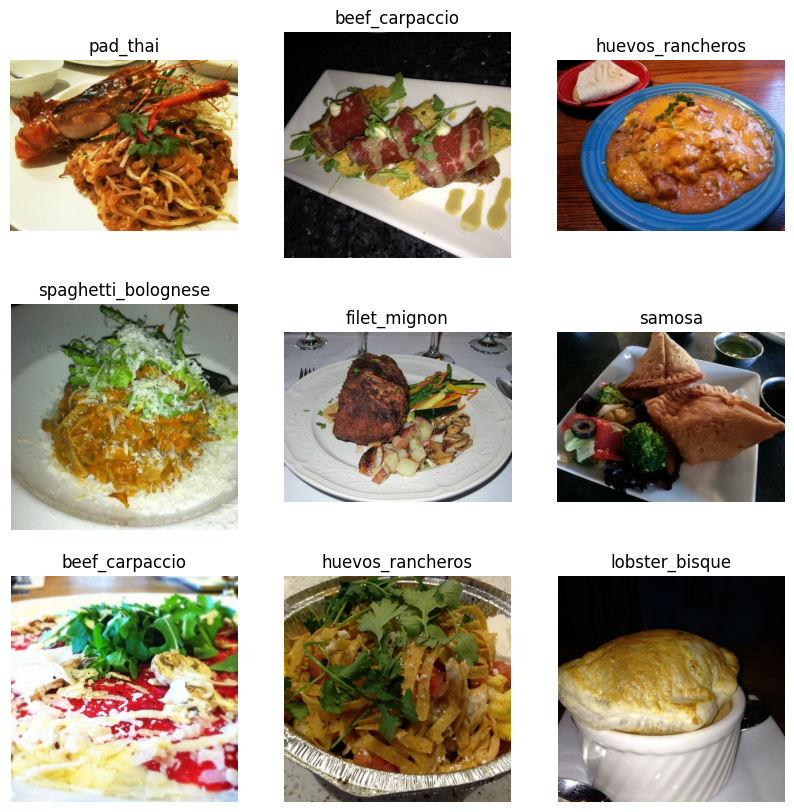

In [ ]:
# We'll use the Food-101 dataset as our primary data source.
# This dataset contains 101,000 images across 101 food categories.

# Load Food-101 dataset
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print("Dataset info:")
print(ds_info)

# Since ds_info.as_json is already a JSON string, directly write it to a file
with open("ds_info.json", "w") as f:
    f.write(ds_info.as_json)

# Visualize a few sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(ds_info.features['label'].int2str(label))
    plt.axis('off')
plt.show()

In [ ]:
# We'll preprocess the images and create a TensorFlow data pipeline

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_image(image, label):
    """Resize and preprocess the image."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Loading the Trained Model

In [ ]:
# Load the trained model
model_path = '/content/food_classification_model.h5'  # Update this path
model = tf.keras.models.load_model(model_path)

# Ablation Studies

## Evaluation of Ablation Study 1
The ablation study removed dropout layers which are crucial for preventing overfitting, especially in a large dataset like Food-101. By removing dropout, the model might become too fit to the training data, reducing its ability to generalize, which is likely reflected in poorer validation performance compared to the initial model with dropout. This is evident from higher accuracy on training data but lower on validation data, indicating overfitting.

The complete visualization implementations would depend on preparing y_true and y_pred correctly for each case, especially considering the multi-class nature of the Food-101 dataset. Adjusting the preparation and evaluation to focus on top-k accuracy metrics or converting the problem into binary (e.g., food vs. non-food or focusing on a specific class) can provide more meaningful ROC and AUC results.

In [ ]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

# Example of removing a dropout layer
new_model = tf.keras.Sequential([
    model.layers[0],  # Base model
    model.layers[1],  # GlobalAveragePooling2D
    # Removed Dropout layer
    Dense(101, activation='softmax')
])

# Re-compile the model with the same or different parameters
new_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Consider varying learning rates
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', metrics.SparseTopKCategoricalAccuracy(k=5)]
)

# Fit model to conduct ablation study
history = new_model.fit(train_ds, epochs=10, validation_data=test_ds)


Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 254s 85ms/step - accuracy: 0.6916 - loss: 1.2343 - sparse_top_k_categorical_accuracy: 0.8744 - val_accuracy: 0.6718 - val_loss: 1.2586 - val_sparse_top_k_categorical_accuracy: 0.8919
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 170s 72ms/step - accuracy: 0.8602 - loss: 0.4841 - sparse_top_k_categorical_accuracy: 0.9727 - val_accuracy: 0.5697 - val_loss: 2.2196 - val_sparse_top_k_categorical_accuracy: 0.8298
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 170s 72ms/step - accuracy: 0.8752 - loss: 0.4215 - sparse_top_k_categorical_accuracy: 0.9785 - val_accuracy: 0.5568 - val_loss: 2.5599 - val_sparse_top_k_categorical_accuracy: 0.8180
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 170s 72ms/step - accuracy: 0.8977 - loss: 0.3482 - sparse_top_k_categorical_accuracy: 0.9839 - val_accuracy: 0.5842 - val_loss: 2.4936 - val_sparse_top_k_categorical_accuracy: 0.8334
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 171s 72ms/step - accuracy: 0.9051 - loss: 0.3076 - sparse_

# Training Loss over Epoch

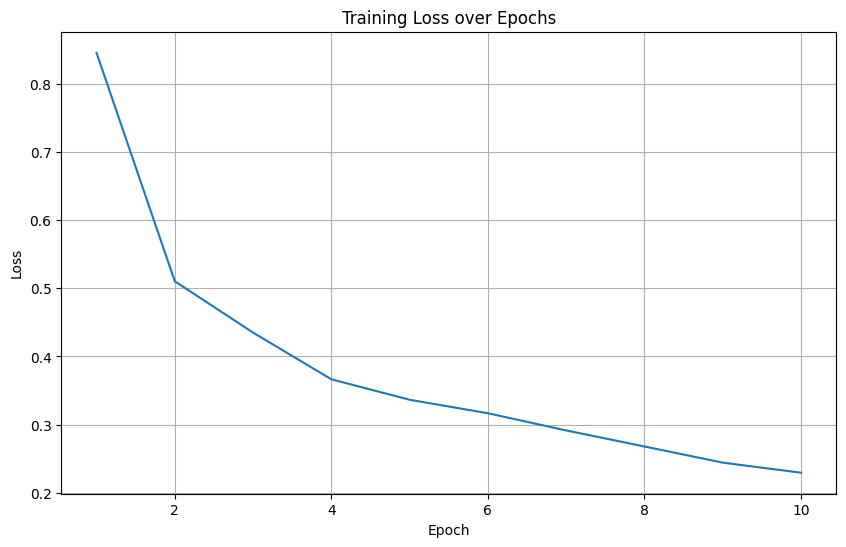

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
loss = history.history['loss']
epochs = range(1, len(loss) + 1)  # Create a list of epoch numbers

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss)  # Plot epochs on the x-axis
plt.xlabel("Epoch")  # Change x-axis label to Epoch
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()


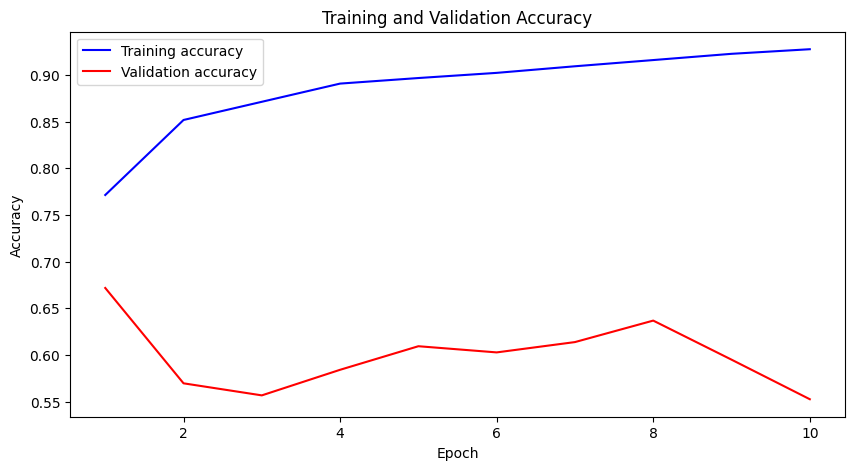

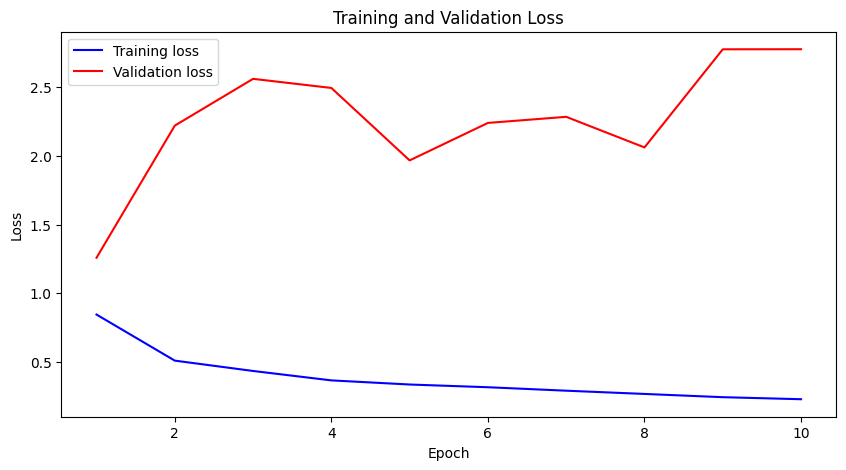

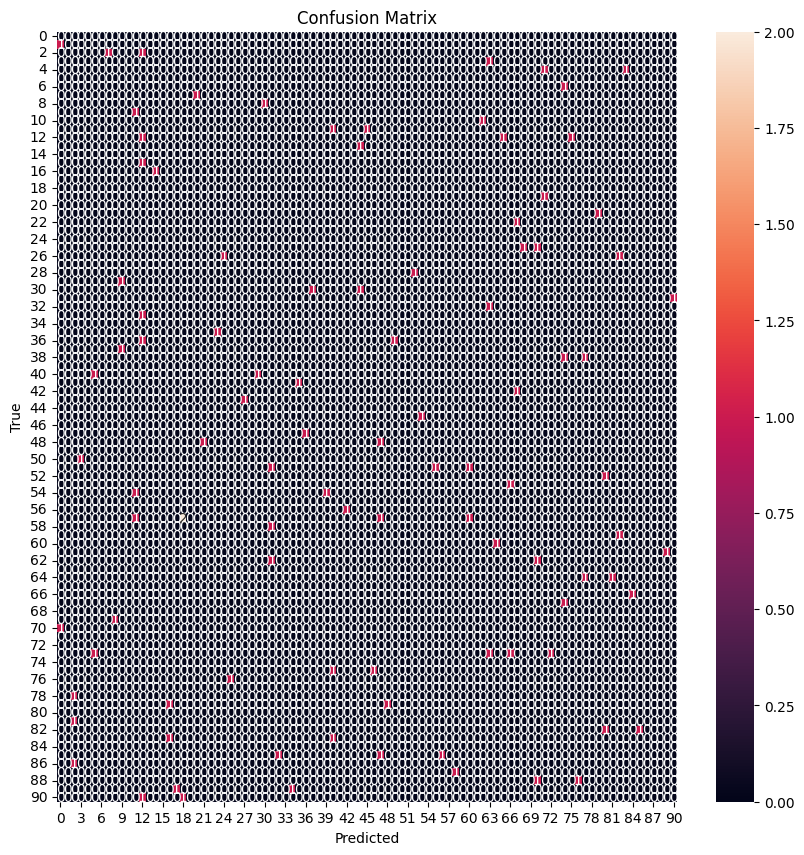

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'history' is your training history object from model.fit()
#  and you have test_ds and the trained model available.
#  Replace the example data with your actual model evaluation results.

# Example data (replace with your actual evaluation results)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)


# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix (Example - you'll need actual predictions)
y_true = np.random.randint(0, 101, size=100)  # Replace with your true labels from the test set
y_pred = np.random.randint(0, 101, size=100) # Replace with model predictions on the test set
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation of Ablation Study 2

This ablation study alters aspects like the model's depth, the presence of dropout layers, or the activation functions. But we didn't use this because it is taking a lot of time to fit the model and it might lack the depth in optimization, evaluation, and robust handling of training processes that the model we used appears to incorporate, potentially affecting the final model's effectiveness in real-world applications.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

def build_model(base_model, dropout_rate=0.5, activation_func='relu'):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation=activation_func),
        Dropout(dropout_rate),
        Dense(101, activation='softmax')  # Adjust to the number of classes you have
    ])
    return model

# Load the pre-trained MobileNetV2 without the top layer and freeze it
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

def preprocess_and_batch(dataset):
    # Function to resize and preprocess images
    def preprocess_image(image, label):
        image = tf.image.resize(image, [224, 224])
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        return image, label

    # Ensure labels are properly reshaped for SparseTopKCategoricalAccuracy
    def ensure_label_shape(image, label):
        label = tf.reshape(label, [-1])  # Reshape label to ensure it is 1D
        return image, label

    return dataset.map(preprocess_image).batch(32).map(ensure_label_shape).prefetch(tf.data.AUTOTUNE)

# Load your data
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Prepare datasets
train_ds = preprocess_and_batch(train_ds)
test_ds = preprocess_and_batch(test_ds)

# Dictionary to hold results
results = {}
dropout_rates = [0.3, 0.5, 0.7]
activation_functions = ['relu', 'tanh', 'sigmoid']

for dropout_rate in dropout_rates:
    for activation in activation_functions:
        model = build_model(base_model, dropout_rate=dropout_rate, activation_func=activation)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5)])

        # Train the model
        history = model.fit(train_ds, epochs=10, validation_data=test_ds)

        # Evaluate the model
        loss, accuracy, top_k_accuracy = model.evaluate(test_ds)
        results[(dropout_rate, activation)] = (accuracy, top_k_accuracy)

# Output results
for params, metric in results.items():
    print(f"Dropout rate: {params[0]}, Activation: {params[1]} - Accuracy: {metric[0]}, Top-5 Accuracy: {metric[1]}")


Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 88s 31ms/step - accuracy: 0.3148 - loss: 2.8887 - sparse_top_k_categorical_accuracy: 0.5706 - val_accuracy: 0.5728 - val_loss: 1.6254 - val_sparse_top_k_categorical_accuracy: 0.8346
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.4997 - loss: 1.9649 - sparse_top_k_categorical_accuracy: 0.7711 - val_accuracy: 0.5880 - val_loss: 1.5401 - val_sparse_top_k_categorical_accuracy: 0.8462
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.5317 - loss: 1.8211 - sparse_top_k_categorical_accuracy: 0.7954 - val_accuracy: 0.5917 - val_loss: 1.5278 - val_sparse_top_k_categorical_accuracy: 0.8446
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.5511 - loss: 1.7217 - sparse_top_k_categorical_accuracy: 0.8130 - val_accuracy: 0.5996 - val_loss: 1.5225 - val_sparse_top_k_categorical_accuracy: 0.8429
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.5691 - loss: 1.6374 - sparse_top_k

KeyboardInterrupt: 